In [1]:
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)

from tomoSegmentPipeline.losses import Tversky_loss
from tomoSegmentPipeline.utils.common import read_array
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer

PARENT_PATH = setup.PARENT_PATH

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
import os
from glob import glob

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

train_tomos = ['tomo02', 'tomo03', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo32', 'tomo10']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38', 'tomo04']
concat_test_ids = sorted([s.replace('tomo', '') for s in test_tomos])
concat_test_ids = '-'.join(concat_test_ids)

# Full tomogram prediction

From the tensorboard logs, we see that there is a gap on the validation losses when comparing models trained with cryoCARE data versus rawCET data. The validation losses for models using cryoCARE data are usually lower than training with rawCET.

Version 2 is the one which has the best validation loss for the Baseline model for both data sets, so we compare this ones first.

- I want to see if the patch size changes the amount of noise we are predicting, specially for raw inputs.

## CryoCARE

In [2]:
model_fileList = ['data/model_logs/models_1/logs/BaselineModel/cryoCARE/train02-03-17/version_2/Baseline_ep1000_in56_lr0.000100_2.model',
                  'data/model_logs/models_1/logs/BaselineModel/cryoCARE/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model',
                  'data/model_logs/incremental_models/logs/BaselineModel/cryoCARE/train02-03-17/nPatches_32/version_0/Baseline_cryoCARE_ep1000_in84_lr0.000100_0.model']

model_fileList = [os.path.join(PARENT_PATH, f) for f in model_fileList]

n_centers_list = [28, 14, 14]

In [3]:
tomo_file_cryoCARE = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_bin4_denoised_0000.nii.gz'

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

for tomo in test_tomos:
    print('###############', tomo)
    tomo_file = tomo_file_cryoCARE %tomo
    label_file = aux_label_file %tomo
    class1_predDict, dice1_dict, classes, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, label_file, True, is_model_data=False)
    print(dice1_dict, '\n')

############### tomo38
Predicting full tomogram using 28 centers...


100%|██████████| 10976/10976 [02:37<00:00, 69.51it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.47it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.50it/s]


{'train02-03-17/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9936, 0.7998], device='cuda:0'), 'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9941, 0.8004], device='cuda:0'), 'nPatches_32/Baseline_cryoCARE_ep1000_in84_lr0.000100_0': tensor([0.9955, 0.8494], device='cuda:0')} 

############### tomo04
Predicting full tomogram using 28 centers...


100%|██████████| 10976/10976 [02:39<00:00, 68.86it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:52<00:00, 26.15it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:52<00:00, 26.12it/s]


{'train02-03-17/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9931, 0.8103], device='cuda:0'), 'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9872, 0.6895], device='cuda:0'), 'nPatches_32/Baseline_cryoCARE_ep1000_in84_lr0.000100_0': tensor([0.9915, 0.7770], device='cuda:0')} 



## RawCET

In [4]:
model_fileList = ['data/model_logs/models_1/logs/BaselineModel/rawCET/train02-03-17/version_2/Baseline_ep1000_in56_lr0.000100_2.model',
                  'data/model_logs/models_1/logs/BaselineModel/rawCET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model',
                  'data/model_logs/incremental_models/logs/BaselineModel/rawCET/train02-03-17/nPatches_32/version_1/Baseline_rawCET_ep1000_in84_lr0.000100_1.model']

model_fileList = [os.path.join(PARENT_PATH, f) for f in model_fileList]

n_centers_list = [28, 14, 14]

In [5]:
tomo_file_rawCET = '/home/haicu/jeronimo.carvajal/Thesis/data/raw_cryo-ET/%s.mrc'

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

for tomo in test_tomos:
    print('###############', tomo)
    tomo_file = tomo_file_rawCET %tomo
    label_file = aux_label_file %tomo
    class1_predDict, dice1_dict, classes, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, label_file, True, is_model_data=False)
    print(dice1_dict, '\n')

############### tomo38
Predicting full tomogram using 28 centers...


100%|██████████| 10976/10976 [02:40<00:00, 68.39it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.43it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:53<00:00, 25.86it/s]


{'train02-03-17/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9942, 0.7969], device='cuda:0'), 'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9907, 0.6467], device='cuda:0'), 'nPatches_32/Baseline_rawCET_ep1000_in84_lr0.000100_1': tensor([0.9944, 0.7985], device='cuda:0')} 

############### tomo04
Predicting full tomogram using 28 centers...


100%|██████████| 10976/10976 [02:41<00:00, 67.99it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.45it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:53<00:00, 25.88it/s]


{'train02-03-17/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9914, 0.7344], device='cuda:0'), 'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9883, 0.6470], device='cuda:0'), 'nPatches_32/Baseline_rawCET_ep1000_in84_lr0.000100_1': tensor([0.9895, 0.6959], device='cuda:0')} 



## IsoNet

In [6]:
model_fileList = ['data/model_logs/models_1/logs/BaselineModel/isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model']

model_fileList = [os.path.join(PARENT_PATH, f) for f in model_fileList]

n_centers_list = [14]

In [7]:
tomo_file_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/RAW_dataset/RAW_corrected_i30/%s_corrected.mrc'
aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

for tomo in test_tomos:
    print('###############', tomo)
    tomo_file = tomo_file_isoNET %tomo
    label_file = aux_label_file %tomo
    class1_predDict, dice1_dict, classes, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, label_file, True, is_model_data=False)
    print(dice1_dict, '\n')

############### tomo38
Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:52<00:00, 26.38it/s]


{'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9940, 0.7893], device='cuda:0')} 

############### tomo04
Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:52<00:00, 26.38it/s]


{'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9905, 0.7259], device='cuda:0')} 



## CryoCARE + IsoNet

In [8]:
model_fileList = ['data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model']

model_fileList = [os.path.join(PARENT_PATH, f) for f in model_fileList]

n_centers_list = [14]

In [9]:
tomo_file_cryoCARE_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/%s_bin4_denoised_0000_corrected.mrc'
aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

for tomo in test_tomos:
    print('###############', tomo)
    tomo_file = tomo_file_cryoCARE_isoNET %tomo
    label_file = aux_label_file %tomo
    class1_predDict, dice1_dict, classes, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, label_file, True, is_model_data=False)
    print(dice1_dict, '\n')

############### tomo38
Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.53it/s]


{'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9937, 0.8007], device='cuda:0')} 

############### tomo04
Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.40it/s]


{'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9918, 0.7813], device='cuda:0')} 



# Compare validation patches of best models across datasets

In [12]:
best_cryoCARE = 'data/model_logs/models_1/logs/BaselineModel/cryoCARE/train02-03-17/version_2/Baseline_ep1000_in56_lr0.000100_2.model'
best_rawCET = 'data/model_logs/models_1/logs/BaselineModel/rawCET/train02-03-17/version_0/Baseline_ep1000_in84_lr0.000300_0.model'
best_isoNET = 'data/model_logs/models_1/logs/BaselineModel/isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model'
best_cryoCARE_isoNET = 'data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model'

model_fileList = [best_cryoCARE, best_rawCET, best_isoNET, best_cryoCARE_isoNET]
model_fileList = [os.path.join(PARENT_PATH, f) for f in model_fileList]

n_centers_list = [4, 2, 2, 2]

In [13]:
tomo_file_cryoCARE, label_file = setup.get_paths(['tomo32'], 'cryoCARE')
tomo_file_cryoCARE, label_file = tomo_file_cryoCARE[0], label_file[0]

tomo_file_rawCET, _ = setup.get_paths(['tomo32'], 'rawCET')
tomo_file_rawCET = tomo_file_rawCET[0]

tomo_file_isoNET, _ = setup.get_paths(['tomo32'], 'isoNET')
tomo_file_isoNET = tomo_file_isoNET[0]

tomo_file_cryoCARE_isoNET, _ = setup.get_paths(['tomo32'], 'cryoCARE+isoNET')
tomo_file_cryoCARE_isoNET = tomo_file_cryoCARE_isoNET[0]
                                       
tomo_fileList = [tomo_file_cryoCARE, tomo_file_rawCET, tomo_file_isoNET, tomo_file_cryoCARE_isoNET]


class_predDict = {}
dice1_dict = {}

Nclass_data = 3
Nclass_model = 2

for model_file, n_centers, tomo_file in zip(model_fileList, n_centers_list, tomo_fileList):
    
    tomogram_data, classes = load_tomoData(tomo_file, label_file)
    z, y, x = tomogram_data.shape

    classes = torch.tensor(classes)

    classes = transpose_to_channels_first(to_categorical(classes, num_classes=Nclass_data))

    y_true = torch.zeros((1, Nclass_data, z, y, x))
    y_true[0, :, :, :, :] = classes    
    
    model = load_model(model_file, Nclass_model, weight_decay=0)
    model_name = model_file.split('/')[-1].replace('.model', '')
    train_tomos = model_file.split('/')[-4]
    input_type = model_file.split('/')[-4]

    key = train_tomos+'/'+model_name

    dim_in = int(model_file.split('in')[-1].split('_')[0])
    
    class_pred = predict_fullTomogram(tomogram_data, model, dim_in, n_centers, Nclass_model)

    class_predDict[key] = class_pred

    y_pred = torch.zeros((1, Nclass_model, z, y, x))
    y_pred[0, :, :, :, :] = transpose_to_channels_first(to_categorical(class_pred, Nclass_model))

    Nclass = min(Nclass_data, Nclass_model)

    dice1 = Tversky_index(y_pred, y_true)
    dice1_dict[key] = dice1

Predicting full tomogram using 4 centers...


100%|██████████| 64/64 [00:00<00:00, 66.41it/s]


Predicting full tomogram using 2 centers...


100%|██████████| 8/8 [00:00<00:00, 24.17it/s]


Predicting full tomogram using 2 centers...


100%|██████████| 8/8 [00:00<00:00, 25.05it/s]


Predicting full tomogram using 2 centers...


100%|██████████| 8/8 [00:00<00:00, 26.24it/s]


In [ ]:
dice1_dict

{'cryoCARE/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9947, 0.9462], device='cuda:0'),
 'rawCET/Baseline_ep1000_in84_lr0.000300_0': tensor([0.9840, 0.8376], device='cuda:0'),
 'isoNET/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9838, 0.8377], device='cuda:0'),
 'cryoCARE+isoNET/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9927, 0.9261], device='cuda:0')}

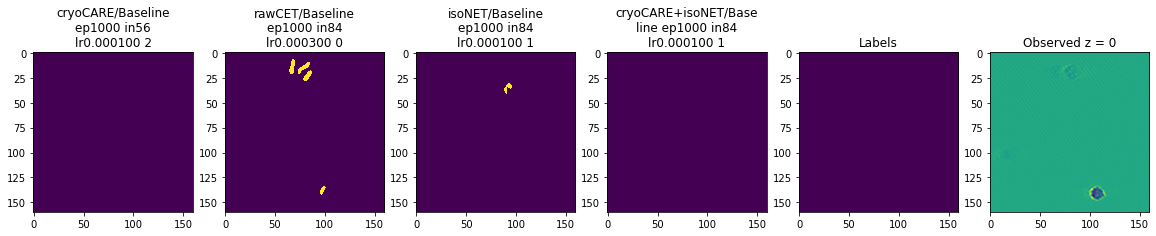

<Figure size 432x288 with 0 Axes>

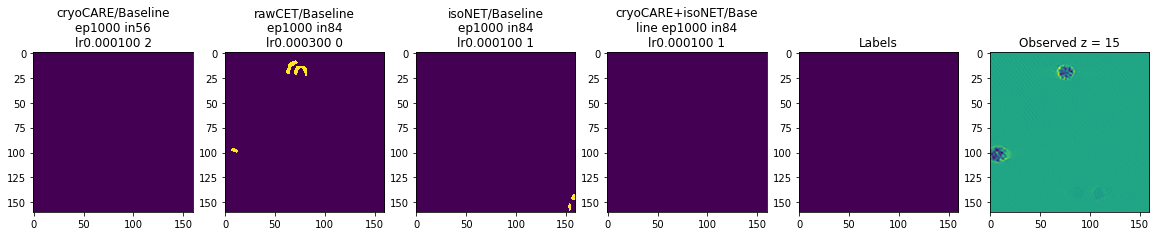

<Figure size 432x288 with 0 Axes>

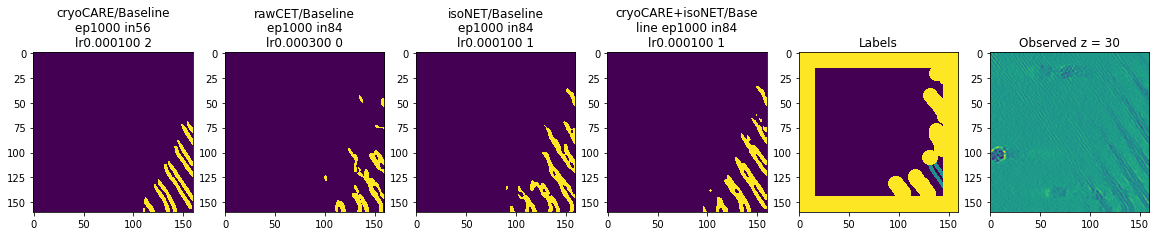

<Figure size 432x288 with 0 Axes>

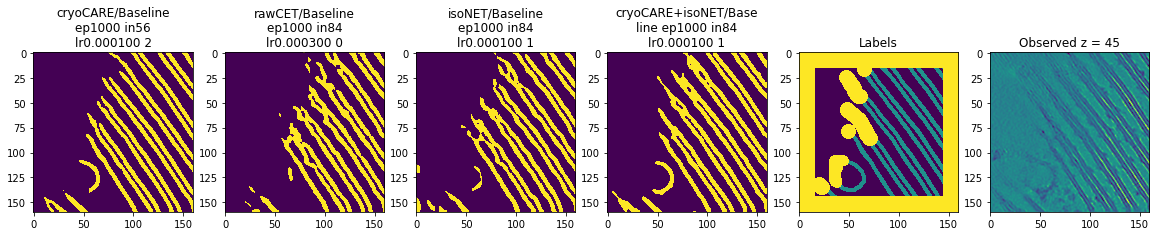

<Figure size 432x288 with 0 Axes>

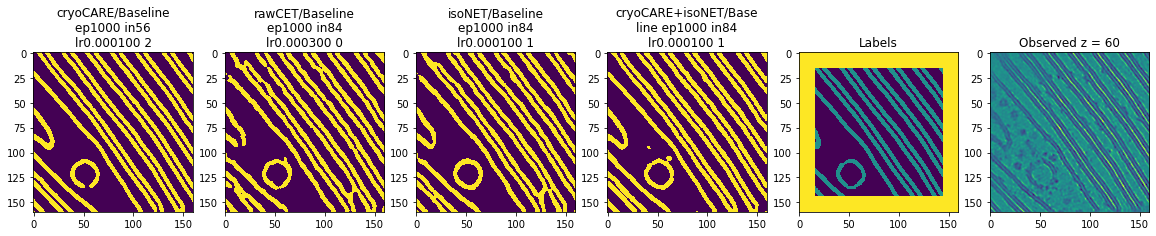

<Figure size 432x288 with 0 Axes>

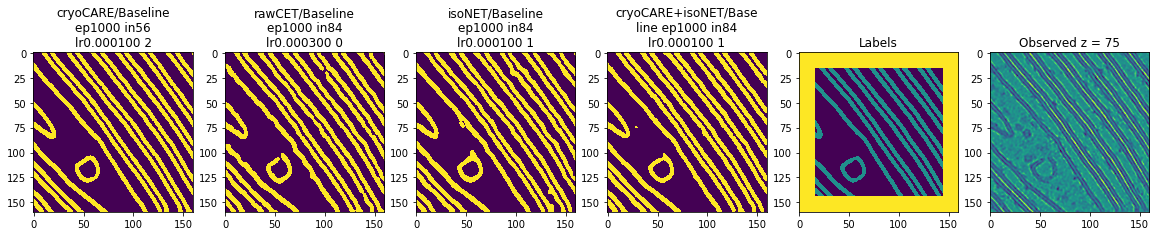

<Figure size 432x288 with 0 Axes>

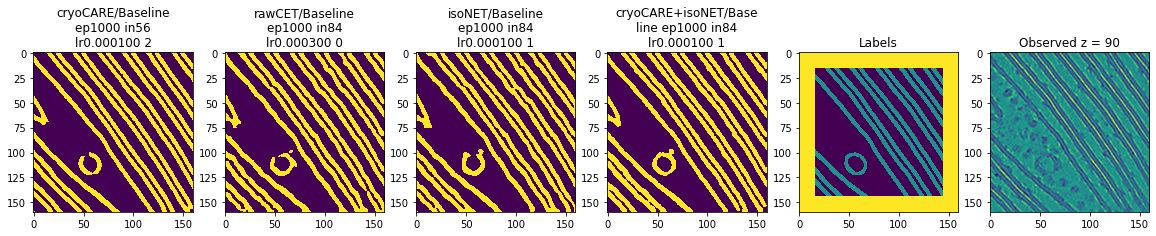

<Figure size 432x288 with 0 Axes>

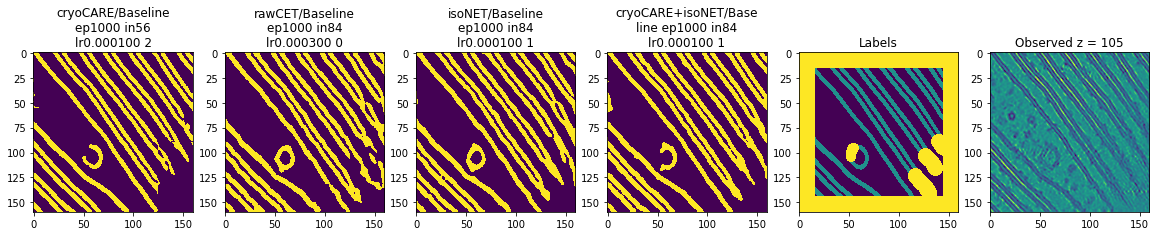

<Figure size 432x288 with 0 Axes>

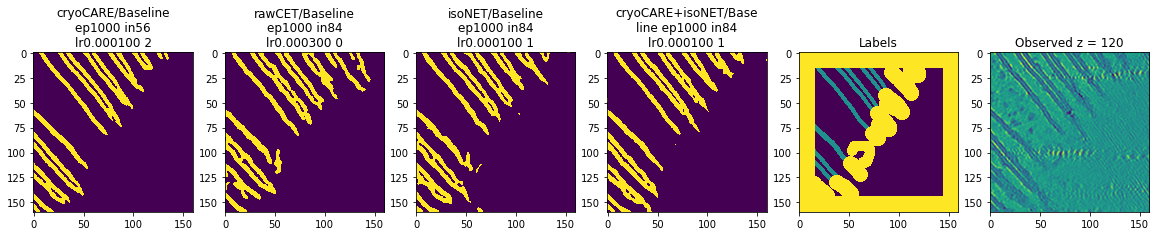

<Figure size 432x288 with 0 Axes>

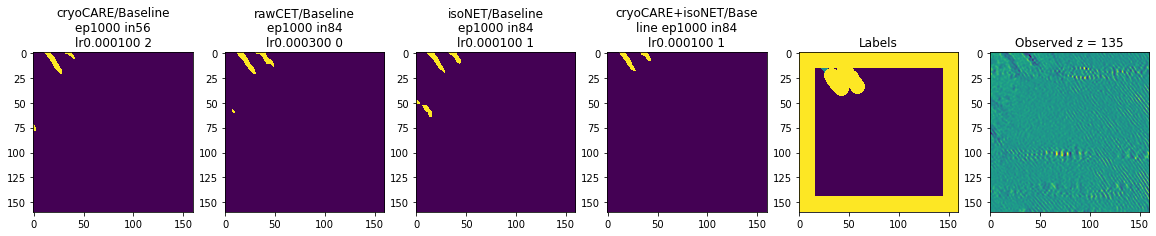

<Figure size 432x288 with 0 Axes>

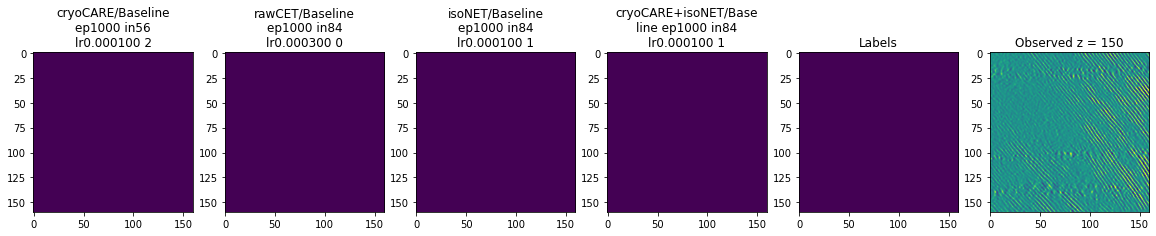

<Figure size 432x288 with 0 Axes>

In [11]:
make_comparison_plot(class_predDict, classes, tomogram_data)